In [1]:
pip install tensorflow scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


C:\Users\sumit\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


--- Loading Data ---
Loading 2057 images... (This might take a minute)
Using features: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'lat', 'long']
Images shape: (2057, 64, 64, 3)
Stats shape: (2057, 7)

--- Model Architecture ---

--- Starting Training ---
Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 516948.1875 - val_loss: 446819.8750
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 268384.5000 - val_loss: 237084.3281
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 235052.8125 - val_loss: 233161.3906
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 232931.5625 - val_loss: 236050.1406
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 233435.0625 - val_loss: 232729.4531
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 234450.4375 - val_loss: 233966.7188
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 233298.7656 - val_loss: 232050.9375
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 2

Average Error: $225,829.98
Model saved as 'house_price_model.h5'


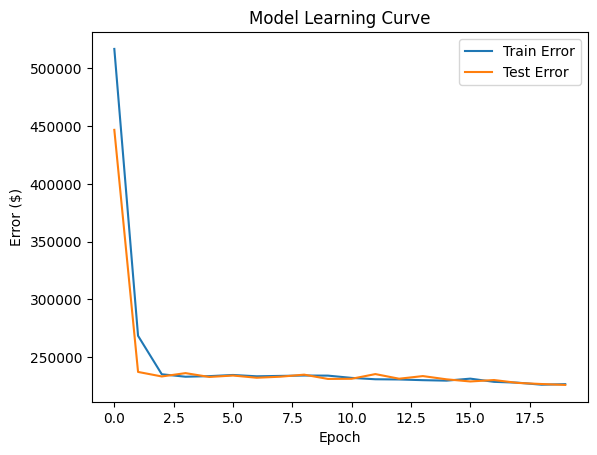

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, Dropout

# ================= CONFIGURATION =================
DATA_FILE = "cleaned_dataset.csv"
IMAGE_DIR = "data/house_images"
IMG_SIZE = 64  # Small size for faster training
BATCH_SIZE = 32
EPOCHS = 20    # How many times to study the data
# =================================================

def load_data():
    print("--- Loading Data ---")
    df = pd.read_csv(DATA_FILE)
    
    # 1. Prepare Images
    print(f"Loading {len(df)} images... (This might take a minute)")
    images = []
    ids_to_drop = []
    
    for index, row in df.iterrows():
        try:
            # Construct path
            img_path = os.path.join(IMAGE_DIR, f"image_{row['id']}.jpg")
            
            # Load and Resize
            img = Image.open(img_path).convert('RGB')
            img = img.resize((IMG_SIZE, IMG_SIZE))
            img_array = np.array(img) / 255.0  # Normalize to 0-1
            images.append(img_array)
        except Exception as e:
            # If image fails, mark row for deletion
            ids_to_drop.append(index)
    
    # Remove bad rows from DataFrame
    if ids_to_drop:
        df = df.drop(ids_to_drop)
        print(f"Dropped {len(ids_to_drop)} bad images.")
    
    X_images = np.array(images)
    
    # 2. Prepare Numerical Data
    # We select specific columns that help predict price
    # Adjust these names if your CSV is slightly different!
    feature_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'lat', 'long']
    
    # Check if columns exist
    available_cols = [c for c in feature_cols if c in df.columns]
    print(f"Using features: {available_cols}")
    
    X_stats = df[available_cols].values
    y_price = df['price'].values
    
    # Normalize Stats (Scale them so 5000 sqft doesn't overpower 3 bedrooms)
    scaler = MinMaxScaler()
    X_stats = scaler.fit_transform(X_stats)
    
    return X_images, X_stats, y_price, scaler

def build_model(img_shape, stats_shape):
    # --- BRANCH 1: IMAGE PROCESSING (CNN) ---
    img_input = Input(shape=img_shape)
    x = Conv2D(32, (3, 3), activation='relu')(img_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    
    # --- BRANCH 2: STATS PROCESSING (ANN) ---
    stats_input = Input(shape=(stats_shape,))
    y = Dense(32, activation='relu')(stats_input)
    y = Dense(16, activation='relu')(y)
    
    # --- MERGE BRANCHES ---
    combined = Concatenate()([x, y])
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.2)(z) # Prevents overfitting
    final_output = Dense(1, activation='linear')(z) # Predict 1 number (Price)
    
    model = Model(inputs=[img_input, stats_input], outputs=final_output)
    model.compile(optimizer='adam', loss='mae') # MAE = Mean Absolute Error
    return model

def main():
    # 1. Load Data
    X_img, X_stats, y, scaler = load_data()
    print(f"Images shape: {X_img.shape}")
    print(f"Stats shape: {X_stats.shape}")
    
    # 2. Split Train/Test
    # We hide 20% of data to test the AI later
    X_img_train, X_img_test, X_stats_train, X_stats_test, y_train, y_test = train_test_split(
        X_img, X_stats, y, test_size=0.2, random_state=42
    )
    
    # 3. Build Model
    model = build_model(X_img.shape[1:], X_stats.shape[1])
    print("\n--- Model Architecture ---")
    # model.summary() # Uncomment to see full structure
    
    # 4. Train
    print("\n--- Starting Training ---")
    history = model.fit(
        [X_img_train, X_stats_train], y_train,
        validation_data=([X_img_test, X_stats_test], y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )
    
    # 5. Evaluate
    print("\n--- Evaluation ---")
    loss = model.evaluate([X_img_test, X_stats_test], y_test)
    print(f"Average Error: ${loss:,.2f}")
    
    # 6. Save Model
    model.save('house_price_model.h5')
    print("Model saved as 'house_price_model.h5'")
    
    # 7. Plot Results
    plt.plot(history.history['loss'], label='Train Error')
    plt.plot(history.history['val_loss'], label='Test Error')
    plt.title('Model Learning Curve')
    plt.ylabel('Error ($)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()